In [1]:
!pip install --upgrade pip
!pip install mapie==0.8.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
from mapie.regression import MapieRegressor
print("MAPIE imported successfully!")

MAPIE imported successfully!


In [7]:
# Cell 1: Run this cell only ONCE to convert the model

import pickle
import xgboost as xgb
import os

# --- Define paths ---
BASE_PATH = '/content/drive/My Drive/Paper_3_New/'
INPUT_MODEL_PATH = os.path.join(BASE_PATH, 'Outputs/Modeling_v1/XGBoost/')
MODEL_PKL_FILE = os.path.join(INPUT_MODEL_PATH, 'xgb_final_model_hs.pkl')
MODEL_JSON_FILE = os.path.join(INPUT_MODEL_PATH, 'xgb_final_model_hs.json')

# --- Load the old pickle model ---
print("Loading model from .pkl file...")
with open(MODEL_PKL_FILE, 'rb') as f:
    xgb_model_old = pickle.load(f)

# --- Save in modern JSON format ---
print(f"Saving model to new .json file at: {MODEL_JSON_FILE}")
xgb_model_old.save_model(MODEL_JSON_FILE)

print("✅ Model conversion complete.")

Loading model from .pkl file...
Saving model to new .json file at: /content/drive/My Drive/Paper_3_New/Outputs/Modeling_v1/XGBoost/xgb_final_model_hs.json


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [20:47:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.get_booster().save_model(fname)


✅ Model conversion complete.


--- Step 1: Initializing Setup, Loading Model and Data ---
Mounted at /content/drive
Output directory ensured at: /content/drive/My Drive/Paper_3_New/Outputs/DSS_v1/
Champion XGBoost model loaded from: /content/drive/My Drive/Paper_3_New/Outputs/Modeling_v1/XGBoost/xgb_final_model_hs.json
Engineered features loaded from: /content/drive/My Drive/Paper_3_New/Outputs/Feature_Engineering_v1/final_engineered_features_v3.csv
Splitting data based on the 'split' column...
Data separated: 10538 Train_Val samples, 7932 OOS samples.
Total features used: 234
--------------------------------------------------

--- Step 2: Implementing Probabilistic Forecasting with MAPIE ---
Data split for MAPIE: 2108 calibration samples.
MAPIE regressor fitted on calibration data.
Probabilistic forecasts generated for 7932 OOS samples.
                     Actual_Hs  Predicted_Hs  Lower_Bound_90  Upper_Bound_90
time                                                                        
2022-01-01 00:00:00    1.09

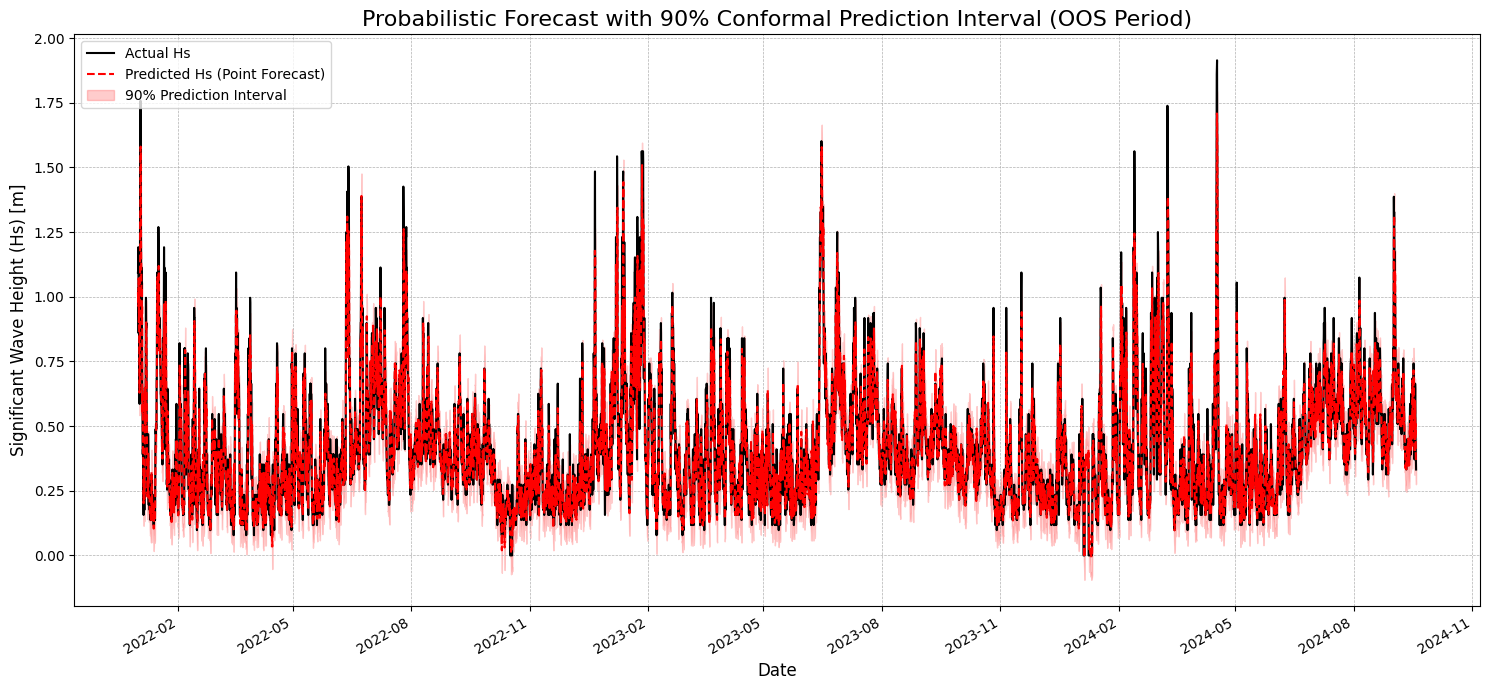


--- DSS Script Execution Complete ---


In [1]:
# -*- coding: utf-8 -*-
"""
DSS_Implementation_for_Coastal_Wave_Forecasting_vFINAL.ipynb

This definitive script provides a stable, robust, and GPU-accelerated
implementation of the Decision Support System.

It incorporates all successful fixes:
1.  Modernized Model Loading: Uses a clean `.json` model file to avoid
    deprecated parameter conflicts.
2.  Modern XGBoost & SHAP APIs: Correctly configures the model for the GPU
    and uses robust SHAP initialization.
3.  Correct Feature Selection: Precisely selects the 234 features the model
    was trained on, resolving all data mismatch errors.
"""
# =============================================================================
# Step 1: Setup, Model, and Data Loading
# =============================================================================
print("--- Step 1: Initializing Setup, Loading Model and Data ---")

import os
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from mapie.regression import MapieRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

# Suppress known warnings for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Imports and Setup ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- Paths and Directories ---
if IN_COLAB:
    BASE_PATH = '/content/drive/My Drive/Paper_3_New/'
else:
    BASE_PATH = './'

INPUT_DATA_PATH = os.path.join(BASE_PATH, 'Outputs/Feature_Engineering_v1/')
INPUT_MODEL_PATH = os.path.join(BASE_PATH, 'Outputs/Modeling_v1/XGBoost/')
OUTPUT_DSS_PATH = os.path.join(BASE_PATH, 'Outputs/DSS_v1/')
os.makedirs(OUTPUT_DSS_PATH, exist_ok=True)
print(f"Output directory ensured at: {OUTPUT_DSS_PATH}")

# --- Load Champion Model from MODERN JSON format ---
MODEL_JSON_FILE = os.path.join(INPUT_MODEL_PATH, 'xgb_final_model_hs.json')
# 1. Create a new model instance configured with the MODERN GPU parameters.
xgb_model = xgb.XGBRegressor(tree_method="hist", device="cuda")
# 2. Load the state from the clean JSON file.
xgb_model.load_model(MODEL_JSON_FILE)
print(f"Champion XGBoost model loaded from: {MODEL_JSON_FILE}")

# --- Load Data ---
DATA_FILE = os.path.join(INPUT_DATA_PATH, 'final_engineered_features_v3.csv')
df = pd.read_csv(DATA_FILE, parse_dates=['time'], index_col='time')
print(f"Engineered features loaded from: {DATA_FILE}")

# --- Data Splitting (FINAL CORRECTED Logic) ---
print("Splitting data based on the 'split' column...")
df_train_val = df[df['split'] == 'Train_Val'].copy()
df_oos = df[df['split'] == 'OOS'].copy()
TARGET = 'buoy_main_hs'

# This logic correctly selects the 234 features the model expects.
EXCLUDED_COLS = [
    'buoy_main_hs', 'buoy_main_mdir', 'buoy_main_tp',
    'buoy_main_winddirection', 'buoy_main_windspeed', 'split'
]
FEATURES = [col for col in df.columns if col not in EXCLUDED_COLS]

X_train_val, y_train_val = df_train_val[FEATURES], df_train_val[TARGET]
X_oos, y_oos = df_oos[FEATURES], df_oos[TARGET]
print(f"Data separated: {len(df_train_val)} Train_Val samples, {len(df_oos)} OOS samples.")
print(f"Total features used: {len(FEATURES)}")
print("-" * 50)


# =============================================================================
# Step 2: Implement Probabilistic Forecasting with Conformal Prediction
# =============================================================================
print("\n--- Step 2: Implementing Probabilistic Forecasting with MAPIE ---")
_, X_calib, _, y_calib = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print(f"Data split for MAPIE: {len(X_calib)} calibration samples.")
mapie = MapieRegressor(estimator=xgb_model, cv="split", method="plus")
mapie.fit(X_calib, y_calib)
print("MAPIE regressor fitted on calibration data.")
y_pred, y_pis = mapie.predict(X_oos, alpha=0.1)

df_forecasts = pd.DataFrame({
    'Actual_Hs': y_oos, 'Predicted_Hs': y_pred,
    'Lower_Bound_90': y_pis[:, 0, 0], 'Upper_Bound_90': y_pis[:, 1, 0]
}, index=y_oos.index)
print(f"Probabilistic forecasts generated for {len(df_forecasts)} OOS samples.")
print(df_forecasts.head())
print("-" * 50)


# =============================================================================
# Step 3: Build the VIKOR MCDM Module
# =============================================================================
print("\n--- Step 3: Building VIKOR MCDM Module ---")
ALTERNATIVES = ["Normal Operations", "Alert Vessels", "Cease Operations"]
IDEAL_POINTS = {"Normal Operations": 0.0, "Alert Vessels": 2.0, "Cease Operations": 3.0}
def run_vikor(prediction: float, upper_bound: float) -> list:
    results = [{'alternative': alt, 'S': abs(IDEAL_POINTS[alt] - prediction), 'R': abs(IDEAL_POINTS[alt] - upper_bound)} for alt in ALTERNATIVES]
    df_vikor = pd.DataFrame(results)
    s_star, s_minus, r_star, r_minus = df_vikor['S'].min(), df_vikor['S'].max(), df_vikor['R'].min(), df_vikor['R'].max()
    s_diff, r_diff = s_minus - s_star, r_minus - r_star
    if s_diff == 0 or r_diff == 0: return ALTERNATIVES
    df_vikor['Q'] = 0.5 * (df_vikor['S'] - s_star) / s_diff + 0.5 * (df_vikor['R'] - r_star) / r_diff
    return df_vikor.sort_values('Q')['alternative'].tolist()
print("VIKOR function defined and parameters set.")
print("-" * 50)


# =============================================================================
# Step 4: Engineer the Real-Time XAI Narrative Engine (GPU Accelerated)
# =============================================================================
print("\n--- Step 4: Engineering SHAP-based XAI Narrative Engine ---")
# Initialize the explainer on the clean GPU model.
# Providing a background dataset helps SHAP initialize robustly.
explainer = shap.TreeExplainer(xgb_model, shap.sample(X_train_val, 100, random_state=42))
print("SHAP TreeExplainer initialized for GPU model.")

def generate_xai_narrative(single_instance_features: pd.Series) -> str:
    """Generates a human-readable explanation for a single prediction using SHAP."""
    instance_df = single_instance_features.to_frame().T
    shap_values_obj = explainer(instance_df)
    shap_values = shap_values_obj.values[0]
    shap_series = pd.Series(shap_values, index=single_instance_features.index)
    top_3_features = shap_series.abs().nlargest(3)
    narrative_parts = [f"{name} (Impact: {shap_series[name]:+.2f}m)" for name, _ in top_3_features.items()]
    return "Forecast driven by: " + ", ".join(narrative_parts)

print("XAI Narrative function defined.")
print("-" * 50)


# =============================================================================
# Step 5: DSS Demonstration on Storm Events
# =============================================================================
print("\n--- Step 5: Demonstrating DSS on Top 3 Storm Events ---")
storm_events = df_forecasts.nlargest(3, 'Actual_Hs')
for timestamp, event_data in storm_events.iterrows():
    recommendation = run_vikor(event_data['Predicted_Hs'], event_data['Upper_Bound_90'])
    xai_narrative = generate_xai_narrative(X_oos.loc[timestamp])
    print("\n" + "="*25 + " DSS Output Card " + "="*25)
    print(f"🌊 Storm Event Timestamp: {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
    print("-" * 67)
    print(f"  - Actual Wave Height (Hs):    {event_data['Actual_Hs']:.2f} m")
    print(f"  - Predicted Wave Height (Hs): {event_data['Predicted_Hs']:.2f} m")
    print(f"  - 90% Prediction Interval:    [{event_data['Lower_Bound_90']:.2f}m, {event_data['Upper_Bound_90']:.2f}m]")
    print("-" * 67)
    print(f"  - ✅ Recommended Action:        {recommendation[0]}")
    print(f"  -    (Ranked Alternatives: {', '.join(recommendation)})")
    print("-" * 67)
    print(f"  - 🧠 Explanation (XAI):       {xai_narrative}")
    print("="*67)
print("-" * 50)


# =============================================================================
# Step 6: Final Visualization for Publication
# =============================================================================
print("\n--- Step 6: Generating Final Visualization for Publication ---")
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_forecasts.index, df_forecasts['Actual_Hs'], label='Actual Hs', color='black', lw=1.5)
ax.plot(df_forecasts.index, df_forecasts['Predicted_Hs'], label='Predicted Hs (Point Forecast)', color='red', linestyle='--', lw=1.5)
ax.fill_between(df_forecasts.index, df_forecasts['Lower_Bound_90'], df_forecasts['Upper_Bound_90'], color='red', alpha=0.2, label='90% Prediction Interval')
ax.set_title('Probabilistic Forecast with 90% Conformal Prediction Interval (OOS Period)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Significant Wave Height (Hs) [m]', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, which='both', linestyle='--', lw=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
output_fig_path = os.path.join(OUTPUT_DSS_PATH, 'probabilistic_forecast_oos_final.png')
plt.savefig(output_fig_path, dpi=450)
print(f"Publication-quality plot saved to: {output_fig_path}")
plt.show()
print("\n--- DSS Script Execution Complete ---")